# Group Project – Team *Aho*
## TOR Drug Listings Analysis

### Cybercrime and Fraud Detection a.y. 2023/2024
#### LUISS Guido Carli

### Group members
- Tommaso Agudio –
- Eyad Ahmed
- Davide Beltrame – 268701
- Cédric Roger
- Tom Rummens

## 1. Exploratory Data Analysis

### 1.1. Importing librairies and tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### 1.2. Overview of the dataset

In [2]:
# Load the dataset
df = pd.read_csv('drug_listings.csv')

# Display the first 5 rows of the dataset
print(df.head())

                               product_title  \
0         10mg Diazepam Tabletten - 10 Stück   
1         10mg Diazepam Tabletten - 50 Stück   
2  Sonderpreis !!! 10x Diazepam Tropfen 25ml   
3   Sonderpreis !!! 2x Diazepam Tropfen 25ml   
4                        1 gr indian Ketamin   

                                 product_description ship_from    ship_to  \
0  - 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...   Germany  Worldwide   
1  10 mg Diazepam / Valium / Valocordin Tabletten...   Germany  Worldwide   
2  Diazepam / Valium / Valocordin Tropfen je Flas...   Germany  Worldwide   
3  Diazepam / Valium / Valocordin Tropfen je Flas...   Germany  Worldwide   
4  Very Strong Ketamin from India be careful\n\ni...   Austria  Worldwide   

            seller    price source  
0  1XAnOYMoUsX1BXx   $67.01   1776  
1  1XAnOYMoUsX1BXx   $93.82   1776  
2  1XAnOYMoUsX1BXx  $938.32   1776  
3  1XAnOYMoUsX1BXx  $214.46   1776  
4           ACAB23   $50.00   1776  


In [3]:
# Display the number of rows and columns in the dataset
print(df.shape)

# Display the columns of the dataset
print(df.columns)

# Display the data types of the columns
print(df.dtypes)

(194433, 7)
Index(['product_title', 'product_description', 'ship_from', 'ship_to',
       'seller', 'price', 'source'],
      dtype='object')
product_title          object
product_description    object
ship_from              object
ship_to                object
seller                 object
price                  object
source                 object
dtype: object


In [4]:
# Display the summary statistics of the dataset
print(df.describe())

               product_title  \
count                 194429   
unique                133799   
top     50x  Grüne Herbalife   
freq                     181   

                                      product_description      ship_from  \
count                                              180439          53229   
unique                                             129209            184   
top     This shipment is with tracking number. The shi...  United States   
freq                                                  241          11456   

          ship_to  seller   price  source  
count       63623  194303  193947  194433  
unique        450    6191  148991       8  
top     Worldwide   rc4me  50 USD   agora  
freq        21273    1848     210  124842  


### 1.3. Handling missing values and duplicates

In [5]:
# Display the number of missing values in each column
print(df.isnull().sum())

# Display the percentage of missing values in each column
# and display the percentages with 2 digits after the decimal point and the % sign
print((df.isnull().sum() / df.shape[0] * 100).round(2).astype(str) + '%')

product_title               4
product_description     13994
ship_from              141204
ship_to                130810
seller                    130
price                     486
source                      0
dtype: int64
product_title            0.0%
product_description      7.2%
ship_from              72.62%
ship_to                67.28%
seller                  0.07%
price                   0.25%
source                   0.0%
dtype: object


In [6]:
# Remove missing values
df_wmv = df.dropna()

In [7]:
# Display the number of unique values in each column
print(df_wmv.nunique())

# Display the percentage of unique values in each column
# and display the percentages with 2 digits after the decimal point and the % sign
print((df_wmv.nunique() / df_wmv.shape[0] * 100).round(2).astype(str) + '%')

product_title          40280
product_description    37277
ship_from                161
ship_to                  376
seller                  3670
price                  35923
source                     6
dtype: int64
product_title          81.72%
product_description    75.62%
ship_from               0.33%
ship_to                 0.76%
seller                  7.45%
price                  72.88%
source                  0.01%
dtype: object


In [8]:
# Check for duplicate rows defined as rows with the same values in all columns
print(df_wmv.duplicated().sum())

# Create a new df without product_description column
df_wmv_nd = df_wmv.drop(columns=['product_description'])

# Check for duplicate rows defined as rows with the same values in all columns
print(df_wmv_nd.duplicated().sum())

# Print 2 rows which have the same values in all columns
print(df_wmv_nd[df_wmv_nd.duplicated(keep=False)].head(2))


0
167
                     product_title ship_from    ship_to       seller   price  \
40  TRAMADOL  50 mg  (20 capsules)   Hungary  Worldwide  BruceWillix  $30.00   
41  TRAMADOL  50 mg  (20 capsules)   Hungary  Worldwide  BruceWillix  $30.00   

   source  
40   1776  
41   1776  


In [9]:
# print rows 40 and 41
print(df_wmv.iloc[40:42])

# print their product_description in full view
pd.set_option('display.max_colwidth', None)

                     product_title  \
40  TRAMADOL  50 mg  (20 capsules)   
41  TRAMADOL  50 mg  (20 capsules)   

                                  product_description ship_from    ship_to  \
40  Tramadol-HCL capsules (50 mg)\n\n***Strong opi...   Hungary  Worldwide   
41  >>>IMPORTANT - Before placing your order pleas...   Hungary  Worldwide   

         seller   price source  
40  BruceWillix  $30.00   1776  
41  BruceWillix  $30.00   1776  


### 1.4. Adjusting data types

In [10]:
# Convert all columns types to string
df_wmv = df_wmv.astype(str)

In [11]:
# Check for characters that are not numerical in the price column
# Display them with their frequencies
print(df_wmv['price'].str.replace(r'[0-9.]', '').value_counts())

# Remove these characters from the price column and add them to a new column: "currency_name"
df_wmv['currency_name'] = df_wmv['price'].str.replace(r'[0-9.]', '')

฿                             24060
BTC                           15765
 USD                           2982
 BTC                           1716
 ฿($)Original   $              1528
 USD - FE                      1427
 ฿(€)Original   €               922
 ฿(£)Original   £               464
 ฿(A$)Original   A$             189
$                               172
 ฿                               61
 ฿(C$)Original   C$               4
~ ฿($)Original p\nrice:  $        2
฿Inf                              1
Name: price, dtype: int64


/var/folders/jt/lhtzzpdd2vs1b862wm2r6ynm0000gn/T/ipykernel_33750/1366543006.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  print(df_wmv['price'].str.replace(r'[0-9.]', '').value_counts())
/var/folders/jt/lhtzzpdd2vs1b862wm2r6ynm0000gn/T/ipykernel_33750/1366543006.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_wmv['currency_name'] = df_wmv['price'].str.replace(r'[0-9.]', '')


In [12]:
# We make a list of these currencies
currencies = df_wmv['currency_name'].unique()

# We remove the currency characters from the price column
df_wmv['price'] = df_wmv['price'].str.replace(r'[^\d.]', '')

# We check how many prices (over the total) can be converted to float
print(pd.to_numeric(df_wmv['price'], errors='coerce').notnull().sum() / df_wmv.shape[0])

0.9369078773862415


/var/folders/jt/lhtzzpdd2vs1b862wm2r6ynm0000gn/T/ipykernel_33750/1056375258.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_wmv['price'] = df_wmv['price'].str.replace(r'[^\d.]', '')


In [13]:
# We cut out the prices that cannot be converted to float
df_wmv = df_wmv[pd.to_numeric(df_wmv['price'], errors='coerce').notnull()]

# We convert the price column to float
df_wmv['price'] = df_wmv['price'].astype(float)

# We print the first 5 values of the price column
print(df_wmv['price'].head())

0     67.01
1     93.82
2    938.32
3    214.46
4     50.00
Name: price, dtype: float64


### 1.5. Insights on Prices

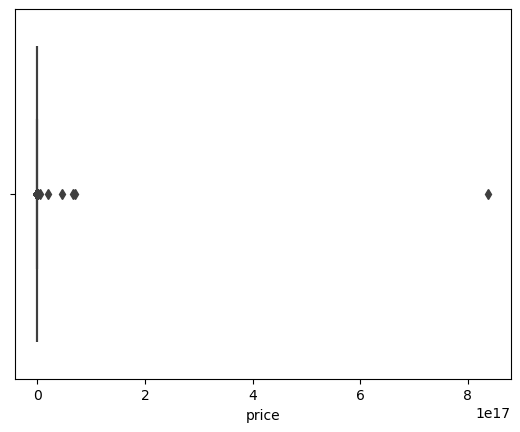

In [14]:
# We check for outliers in the price column
sns.boxplot(x=df_wmv['price'])
plt.show()


In [27]:
# We check for the distribution of the price column
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_wmv.describe()

,price
count,46122.00
mean,69.28
std,1358.33
min,0.00
25%,0.10
50%,0.28
75%,1.28
max,99999.00


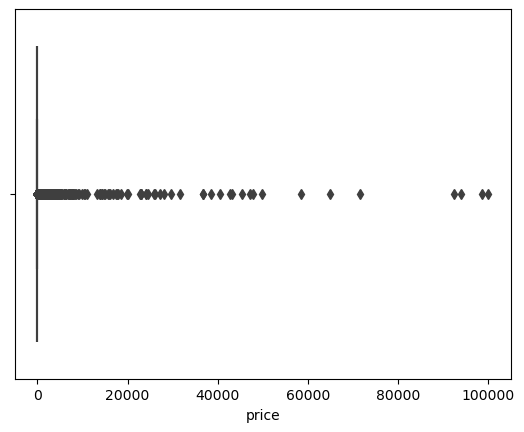

In [16]:
# Since there seems to be a number of extremely high prices, we make a new df without them
# setting the threshold at 100000
df_wmv = df_wmv[df_wmv['price'] < 100000]
# visualising with a boxplot
sns.boxplot(x=df_wmv['price'])
plt.show()

#### 1.5.1. Currencies

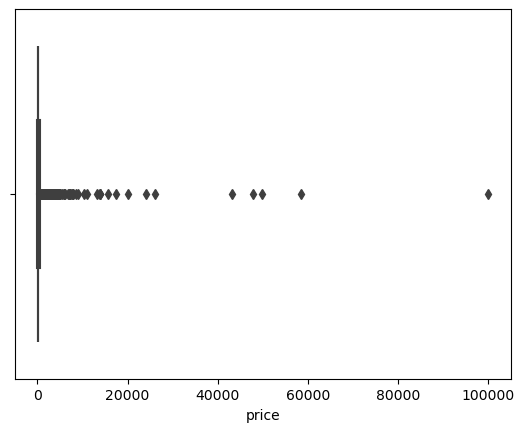

In [17]:
# the boxplot is still invisible, we need to distinguish between prices in BTC and USD
# we make a new df for each currency

# for USD, we filter the rows with currency_name = $ or USD or USD - FE
df_wmv_usd = df_wmv[df_wmv['currency_name'].str.contains('USD|USD - FE|\$')]
# for BTC, we filter the rows where the currency_name isn't missing
df_wmv_btc = df_wmv[df_wmv['currency_name'] != '']

# plot the boxplot for USD
sns.boxplot(x=df_wmv_usd['price'])
plt.show()

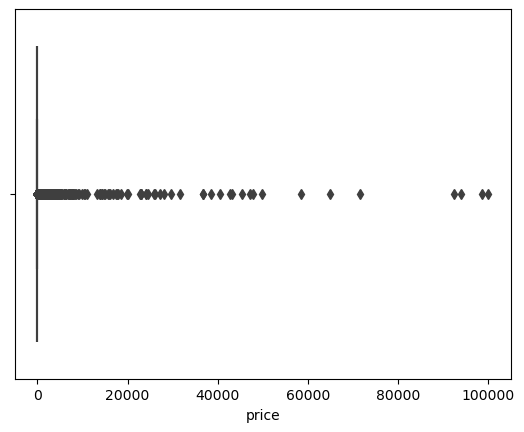

In [18]:
### plot the boxplot for BTC
sns.boxplot(x=df_wmv_btc['price'])
plt.show()

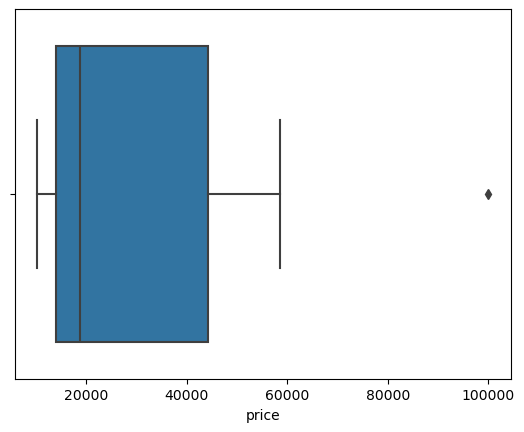

In [19]:
# we try to remove missing values from the USD prices setting a lower cap and then using IQR
# we set the lower cap at 10000
df_wmv_usd = df_wmv_usd[df_wmv_usd['price'] > 10000]
# boxplot
sns.boxplot(x=df_wmv_usd['price'])
plt.show()

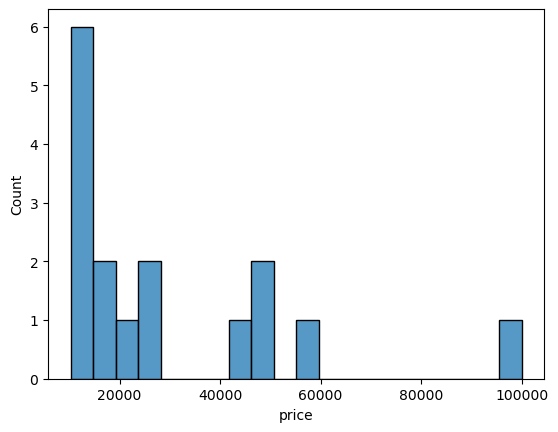

,price
count,16.000000
mean,29921.436250
std,24368.623248
min,10249.980000
25%,13980.000000
50%,18712.490000
75%,44260.100000
max,99999.000000


In [20]:
# now we make a histogram for the usd prices
sns.histplot(df_wmv_usd['price'], bins=20)
plt.show()

df_wmv_usd.describe()


In [21]:
# Display the count of each unique value in the 'product_title' column
print(df['product_title'].value_counts())

50x  Grüne Herbalife                          181
10x  Grüne Herbalife                          164
25x  Grüne Herbalife                          159
5x  Grüne Herbalife                           151
100x  Grüne Herbalife                         150
                                             ... 
Custom order for A****i                         1
BUPRENORPHINE Patch -- 70ug/h -- 40mg --        1
BUPRENORPHINE Patch -- 52,5ug/h -- 30mg --      1
5 x 'Stars' 140mg MDMA                          1
∎∎ Yellow Grenades ∎∎ 170MG MDMA                1
Name: product_title, Length: 133799, dtype: int64


## 2. NLP

In [22]:
# NLP Analysis of the 'product_title' column
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
# running pip install wordcloud if not installed
from wordcloud import WordCloud



# Download the NLTK resources 
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

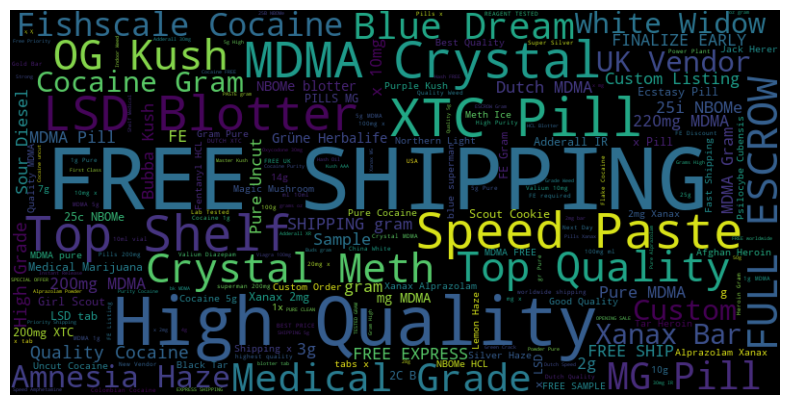

In [23]:
# Create a list of stopwords
stop_words = set(stopwords.words('english'))

# Create a WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a Porter Stemmer
stemmer = PorterStemmer()

# Tokenize the 'product_title' column
# first convert into string
df['product_title'] = df['product_title'].astype(str)
df['product_title_tokens'] = df['product_title'].apply(word_tokenize)
# TypeError: expected string or bytes-like object


# Remove stopwords from the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Lemmatize the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Stem the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Create a WordCloud of the 'product_title' column
text = ' '.join(df['product_title'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

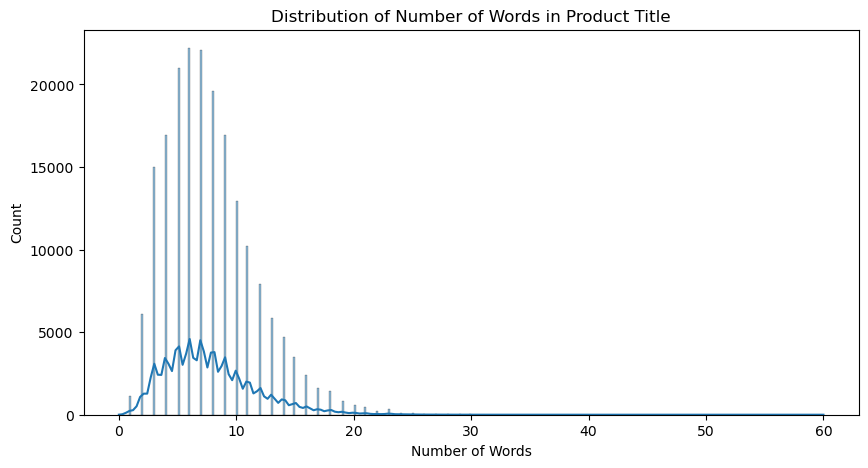

In [24]:
# Visualize the distribution of the 'product_title' column
plt.figure(figsize=(10, 5))
sns.histplot(df['product_title_tokens'].apply(len), kde=True)
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in Product Title')
plt.show()


In [25]:
# print more statistics on the number and type of words in product titles
# Create a new column with the number of words in the 'product_title' column
df['num_words'] = df['product_title_tokens'].apply(len)

# Display the average number of words in the 'product_title' column
print('Average Number of Words in Product Title:', df['num_words'].mean())

# Display the maximum number of words in the 'product_title' column
print('Maximum Number of Words in Product Title:', df['num_words'].max())

# Display the minimum number of words in the 'product_title' column
print('Minimum Number of Words in Product Title:', df['num_words'].min())

# Display the most common words in the 'product_title' column
# exclude special characters and stopwords

# Create a list of special characters
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '+', '=', '{', '}', '[', ']', '|', '\\', ':', ';', '"', "'", '<', '>', ',', '.', '?', '/']

# Create a list of words without special characters
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [word for word in x if word not in special_chars])

words = [word for sublist in df['product_title_tokens'] for word in sublist]
word_freq = nltk.FreqDist(words)
print('Most Common Words in Product Title:', word_freq.most_common(50))

Average Number of Words in Product Title: 7.774529015136319
Maximum Number of Words in Product Title: 60
Minimum Number of Words in Product Title: 0
Most Common Words in Product Title: [('gram', 24463), ('x', 19274), ('mdma', 16990), ('free', 14806), ('ship', 14218), ('1', 13852), ('pill', 13004), ('qualiti', 12674), ('pure', 11958), ('10', 11147), ('cocain', 10398), ('1g', 9257), ('100', 8944), ('crystal', 8008), ('mg', 7792), ('high', 7424), ('fe', 7387), ('5', 7226), ('kush', 6542), ('lsd', 6506), ('grade', 6478), ('tab', 6313), ('50', 5952), ('blotter', 5749), ('xtc', 5410), ('xanax', 5400), ('white', 5288), ('uk', 5125), ('top', 5056), ('--', 5017), ('weed', 5003), ('oz', 4970), ('heroin', 4871), ('hash', 4807), ('2', 4681), ('10mg', 4650), ('blue', 4615), ('5g', 4587), ('indoor', 4582), ('speed', 4543), ('dutch', 4385), ('10g', 4164), ('gr', 4102), ('3.5g', 4099), ('uncut', 3982), ('haze', 3950), ('escrow', 3918), ('7g', 3883), ("'s", 3753), ('powder', 3674)]


In [26]:
# Classification of fraudolent listings using NLP insights
# we classify listings as fraudulent when there are exclamation marks and misspelled words in the product title, such as qualiti

# Create a new column with the number of exclamation marks in the 'product_title' column
df['num_exclamation_marks'] = df['product_title'].apply(lambda x: x.count('!'))

# Create a new column with the number of misspelled words in the 'product_title' column
df['num_misspelled_words'] = df['product_title_tokens'].apply(lambda x: sum([1 for word in x if 'qualiti' in word]))

# Create a new column to classify listings as fraudulent or not
df['is_fraudulent'] = (df['num_exclamation_marks'] > 0) | (df['num_misspelled_words'] > 0)

# Display the count of fraudulent and non-fraudulent listings
print(df['is_fraudulent'].value_counts())

# Display the percentage of fraudulent and non-fraudulent listings
print(df['is_fraudulent'].value_counts(normalize=True))

# True means that the listing is fraudulent, while False means that the listing is not fraudulent.

False    168778
True      25655
Name: is_fraudulent, dtype: int64
False    0.868052
True     0.131948
Name: is_fraudulent, dtype: float64
